# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [2]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [3]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [4]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df['delivery_time_min'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [5]:
# Convert categorical features to category type

for col in ['store_primary_category', 'order_protocol']:
    df[col] = df[col].astype('category')

df.head()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,distance,delivery_time_min
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,34.44,47.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,27.60,44.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,11.56,55.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,31.80,59.0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,8.20,46.0


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [6]:
# Calculate time taken in minutes
import pandas as pd

# assuming you’ve already loaded your DataFrame as df
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# compute time taken in minutes
df['time_taken_min'] = (
    df['actual_delivery_time'] - df['created_at']
).dt.total_seconds() / 60

# inspect
print(df[['created_at', 'actual_delivery_time', 'time_taken_min']].head())

           created_at actual_delivery_time  time_taken_min
0 2015-02-06 22:24:17  2015-02-06 23:11:17            47.0
1 2015-02-10 21:49:25  2015-02-10 22:33:25            44.0
2 2015-02-16 00:11:35  2015-02-16 01:06:35            55.0
3 2015-02-12 03:36:46  2015-02-12 04:35:46            59.0
4 2015-01-27 02:12:36  2015-01-27 02:58:36            46.0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [10]:
# Extract the hour and day of week from the 'created_at' timestamp

df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# extract hour and weekday
df['order_hour'] = df['created_at'].dt.hour
df['order_weekday'] = df['created_at'].dt.day_name()  # e.g. Monday, Tuesday

# drop raw timestamps
df = df.drop(columns=['created_at', 'actual_delivery_time'])

df.head()



KeyError: 'created_at'

In [11]:
# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_weekday'] \
                    .isin(['Saturday','Sunday']) \
                    .map({True: 'Weekend', False: 'Weekday'}) \
                    .astype('category')

In [13]:
df.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'delivery_time_min',
       'time_taken_min', 'order_hour', 'order_weekday', 'isWeekend'],
      dtype='object')

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [14]:
# Define target variable (y) and features (X)
y = df['delivery_time_min']
X = df.drop(columns=['delivery_time_min'])

# Quick sanity check
print("Features shape:", X.shape)
print("Target shape:  ", y.shape)
print("Feature columns:", list(X.columns))

Features shape: (175777, 16)
Target shape:   (175777,)
Feature columns: ['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken_min', 'order_hour', 'order_weekday', 'isWeekend']


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [15]:
# Split data into training and testing sets

from sklearn.model_selection import train_test_split

# Split features and target into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% for testing
    random_state=42      # reproducible split
)

# Verify shapes
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (140621, 16), X_test: (35156, 16)
y_train: (140621,), y_test: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [16]:
# Define numerical and categorical columns for easy EDA and data manipulation

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

Numerical columns: ['market_id', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken_min', 'order_hour']
Categorical columns: ['store_primary_category', 'order_protocol', 'order_weekday', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

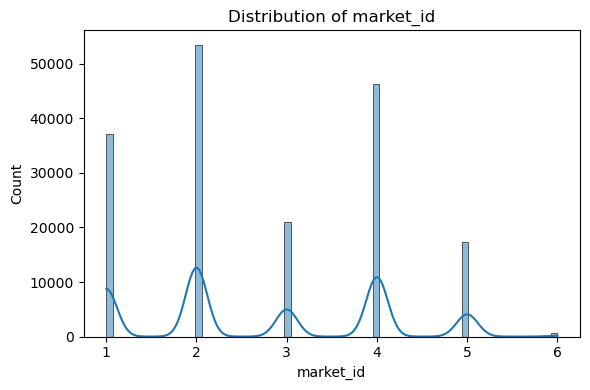

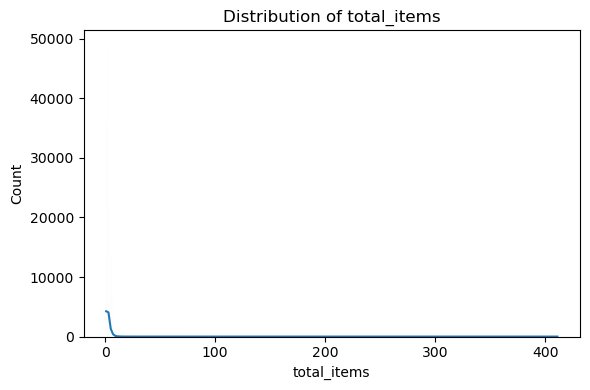

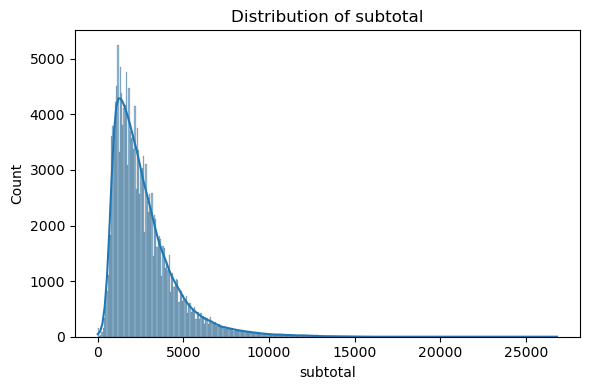

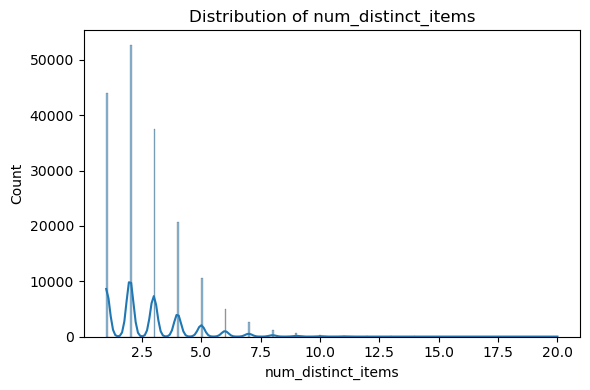

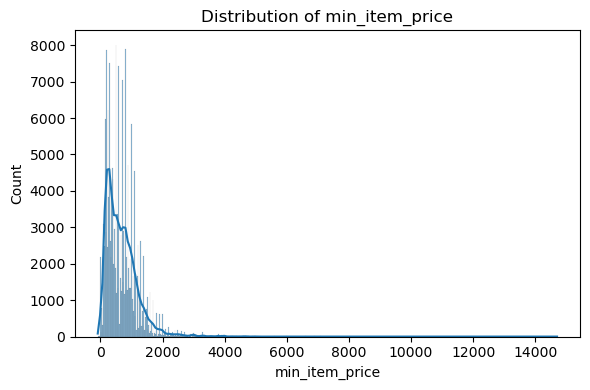

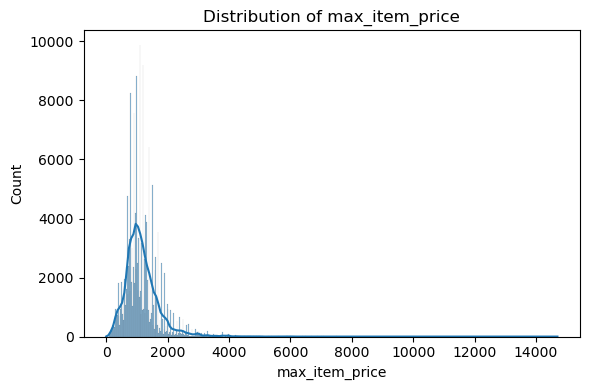

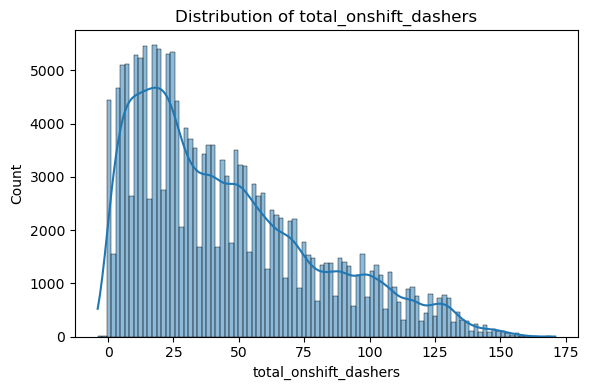

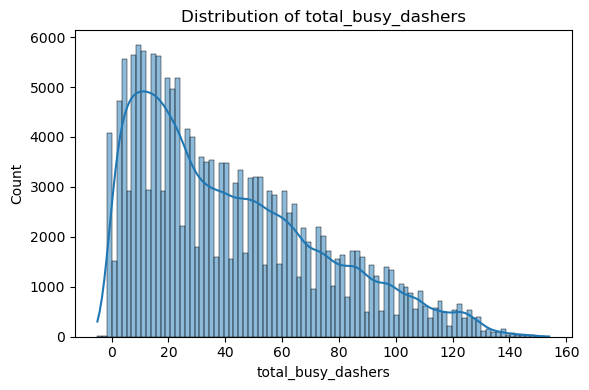

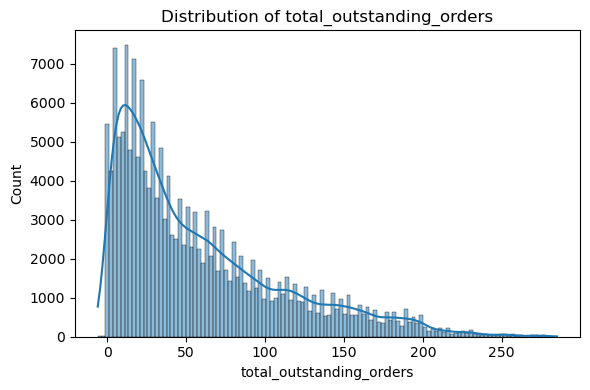

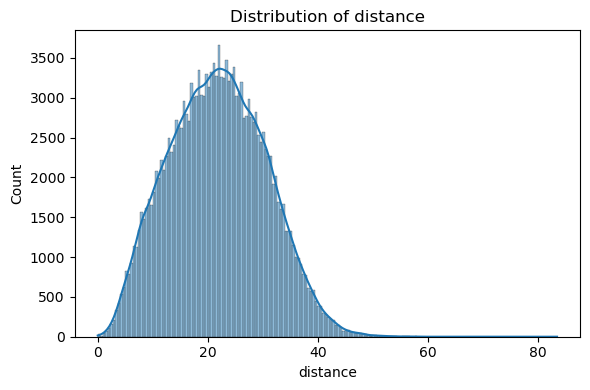

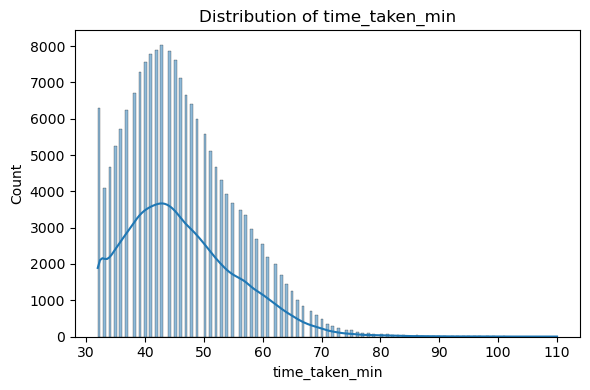

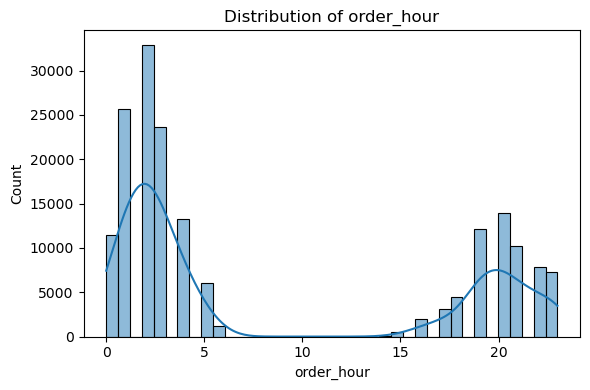

In [17]:
# Plot distributions for all numerical columns

import matplotlib.pyplot as plt
import seaborn as sns

# assuming X is your DataFrame of features
num_cols = X.select_dtypes(include=['number']).columns.tolist()

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

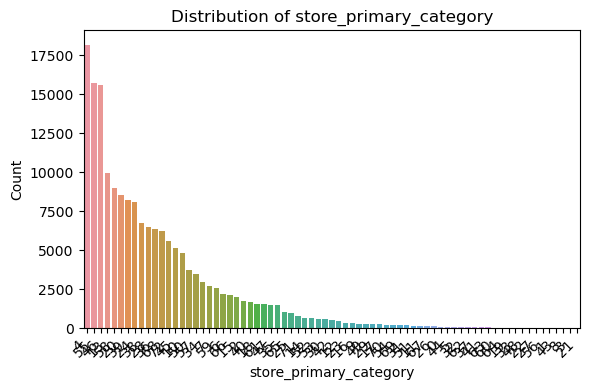

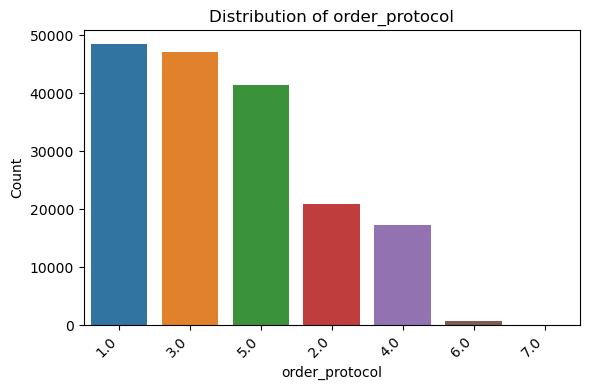

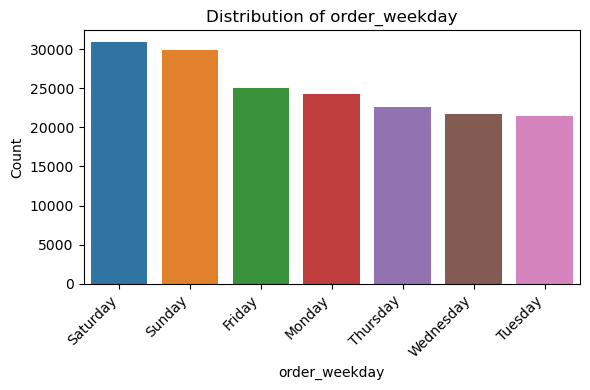

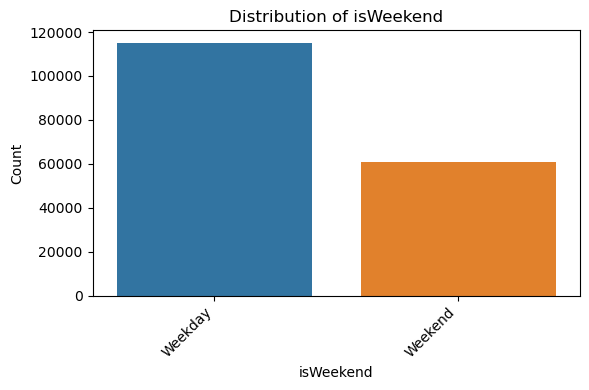

In [18]:
# Distribution of categorical columns
import matplotlib.pyplot as plt
import seaborn as sns

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(
        x=col,
        data=X,
        order=X[col].value_counts().index
    )
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

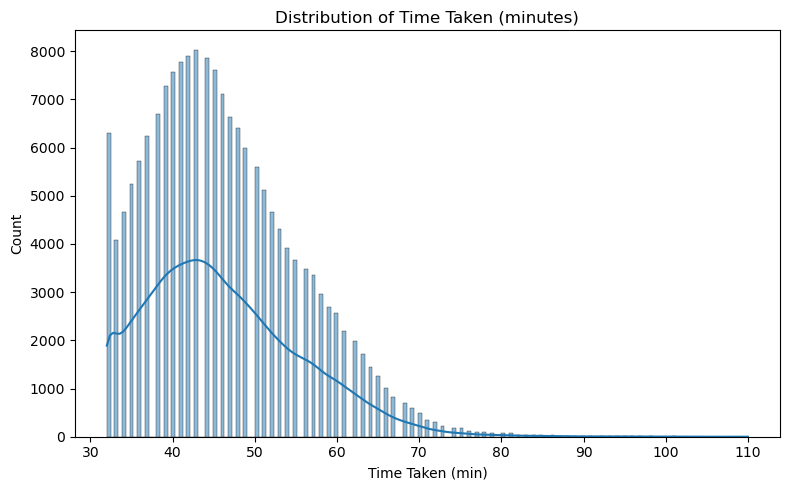

In [19]:
# Distribution of time_taken

import matplotlib.pyplot as plt
import seaborn as sns

# if your column is named time_taken_min, else replace with the correct name
col = 'time_taken_min'  
plt.figure(figsize=(8, 5))
sns.histplot(df[col], kde=True)
plt.title('Distribution of Time Taken (minutes)')
plt.xlabel('Time Taken (min)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

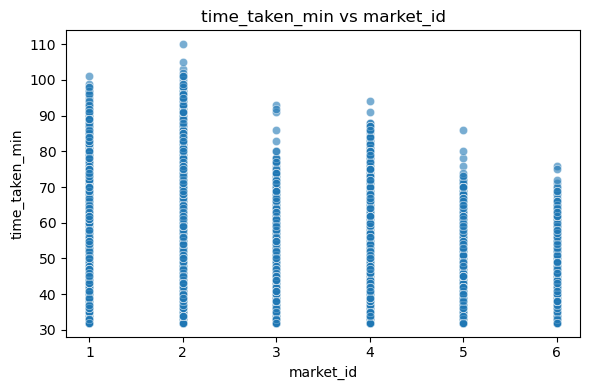

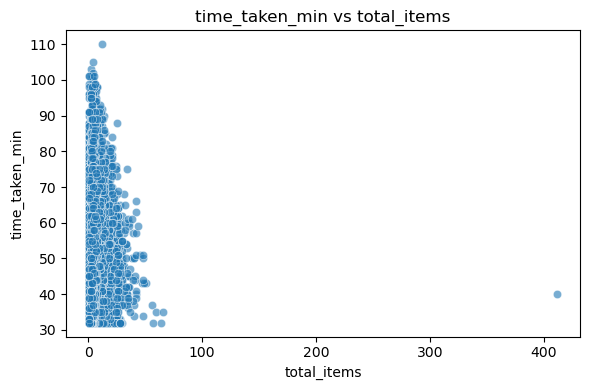

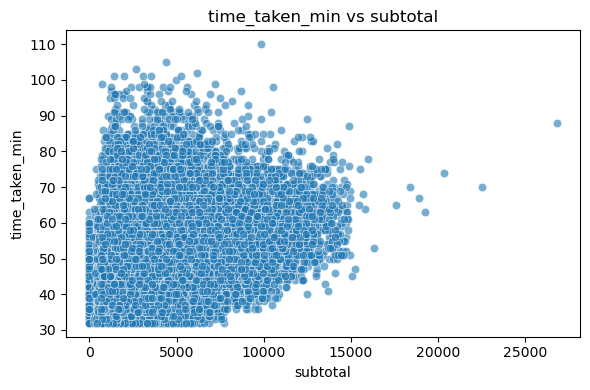

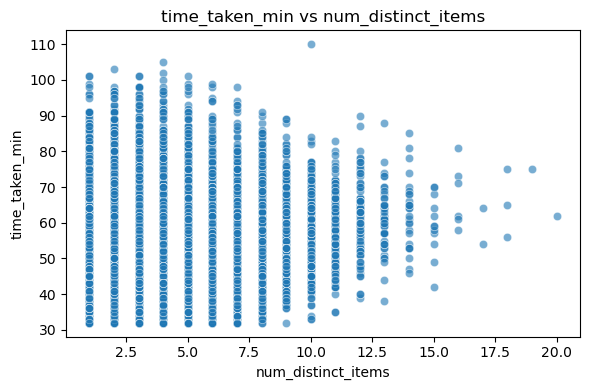

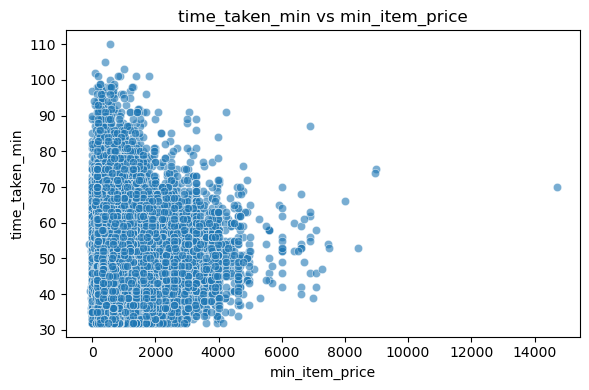

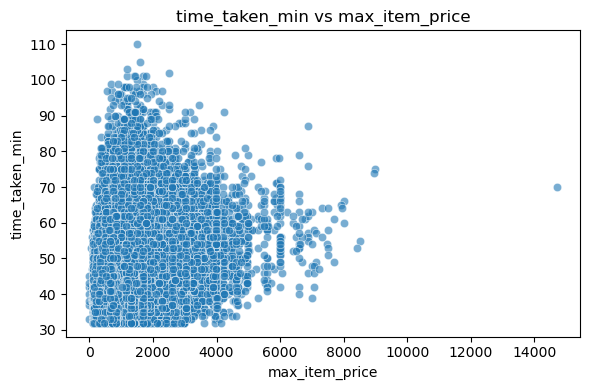

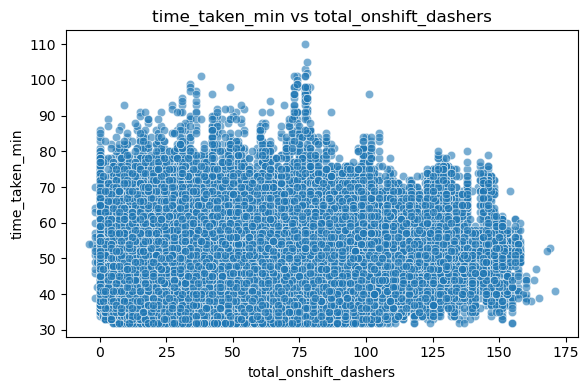

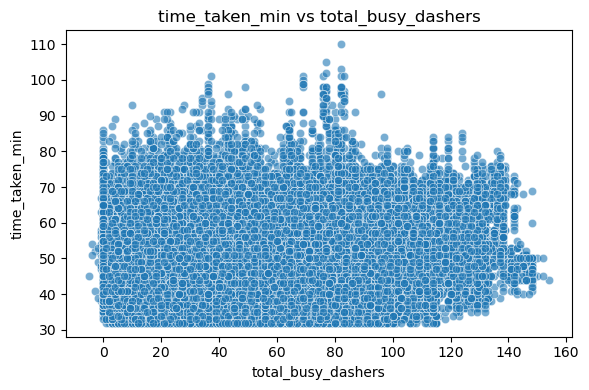

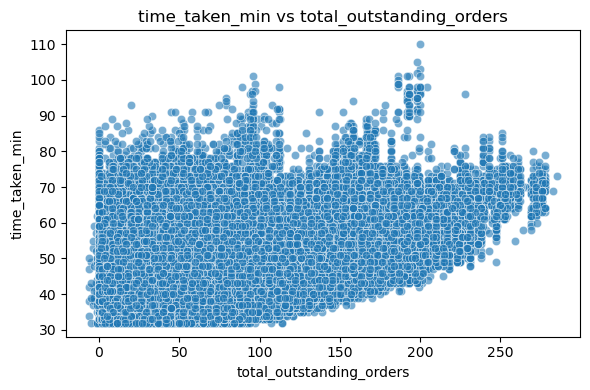

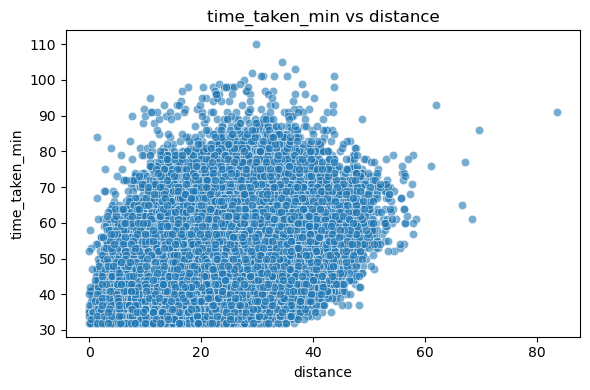

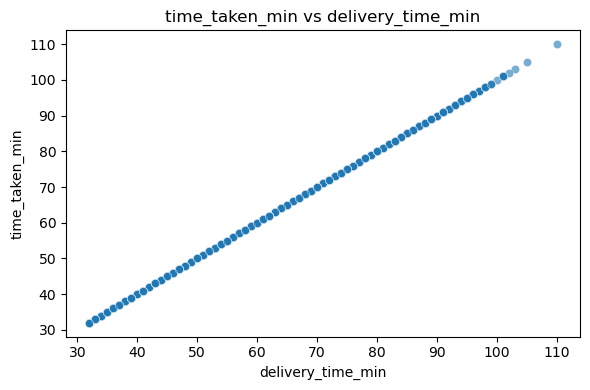

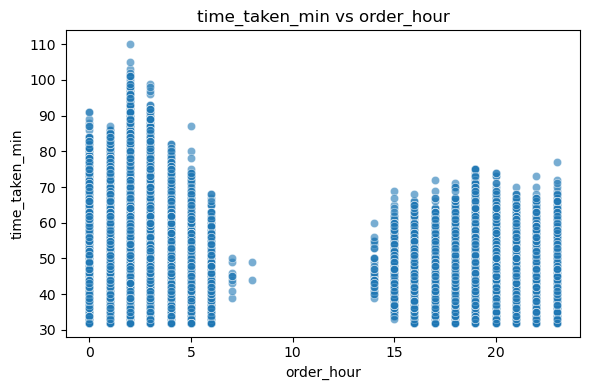

In [20]:
# Scatter plot to visualise the relationship between time_taken and other features

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is df and contains 'time_taken_min'
# Identify numeric feature columns excluding the target
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols.remove('time_taken_min')

# Plot scatter for each numeric feature against time_taken_min
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=col, y='time_taken_min', alpha=0.6)
    plt.xlabel(col)
    plt.ylabel('time_taken_min')
    plt.title(f'time_taken_min vs {col}')
    plt.tight_layout()
    plt.show()


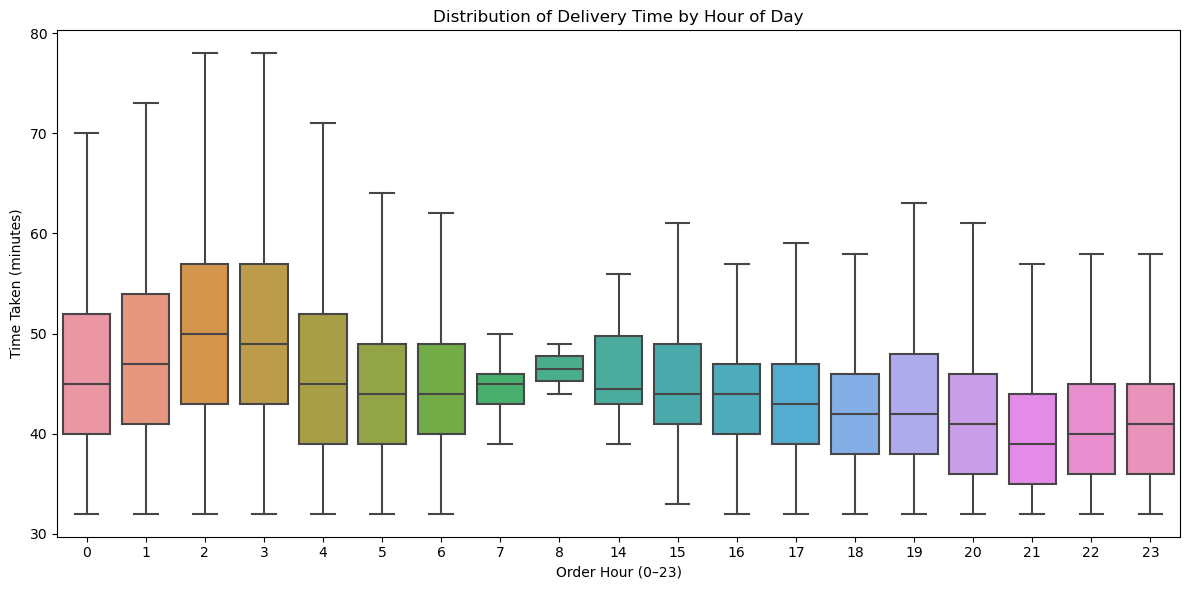

In [21]:
# Show the distribution of time_taken for different hours

import matplotlib.pyplot as plt
import seaborn as sns

# assume df has 'order_hour' and 'time_taken_min'
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='order_hour',
    y='time_taken_min',
    data=df,
    showfliers=False  # hide extreme outliers for clarity
)
plt.title('Distribution of Delivery Time by Hour of Day')
plt.xlabel('Order Hour (0–23)')
plt.ylabel('Time Taken (minutes)')
plt.tight_layout()
plt.show()


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

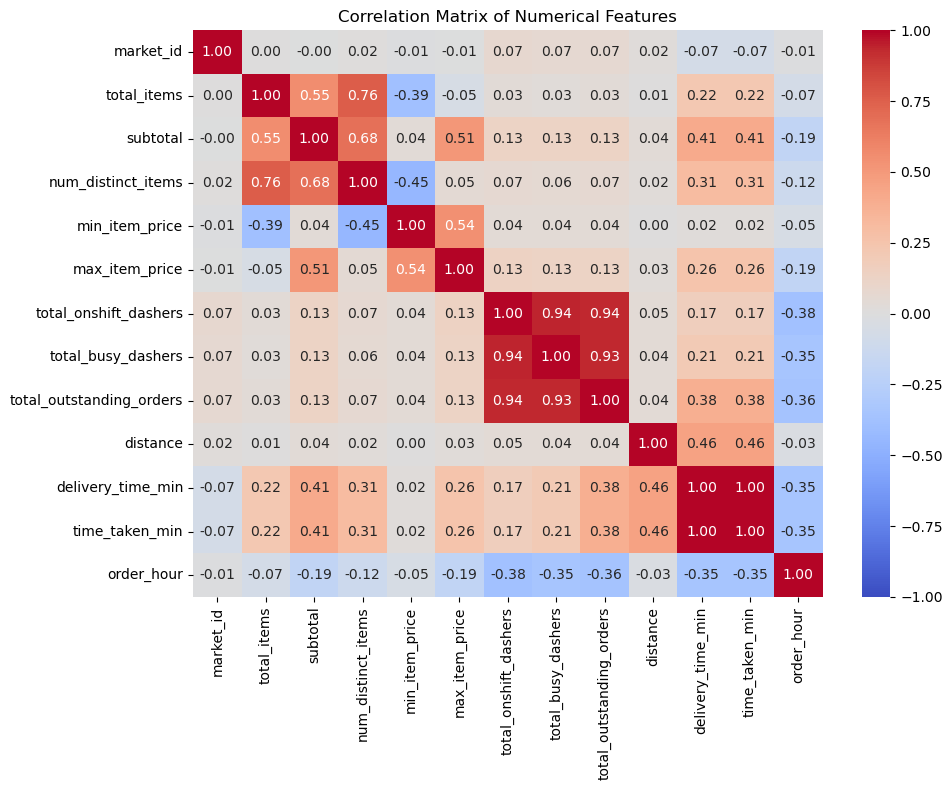

Features most correlated with time_taken_min:
delivery_time_min           1.000000
distance                    0.460173
subtotal                    0.413267
total_outstanding_orders    0.384999
order_hour                  0.346366
num_distinct_items          0.312055
max_item_price              0.255167
total_items                 0.224856
total_busy_dashers          0.206045
total_onshift_dashers       0.171015
market_id                   0.073016
min_item_price              0.022753
Name: time_taken_min, dtype: float64


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# select numeric columns (including the target)
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# compute correlation matrix
corr = df[num_cols].corr()

# plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# print correlations with time_taken_min sorted by strength
print("Features most correlated with time_taken_min:")
print(corr['time_taken_min'].drop('time_taken_min').abs().sort_values(ascending=False))


##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

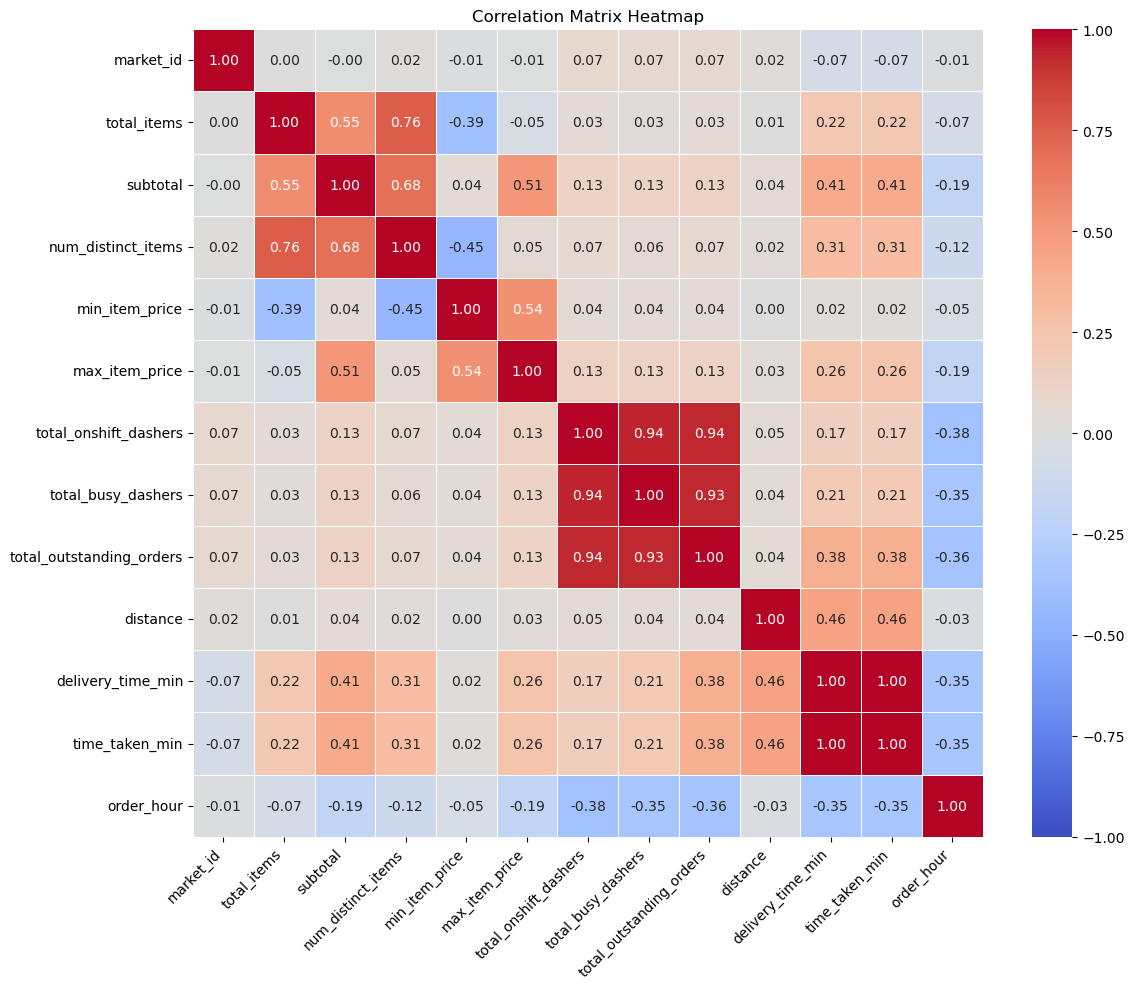

In [23]:
# Plot the heatmap of the correlation matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns (including your target)
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# Compute correlation matrix
corr = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [24]:
# Drop 3-5 weakly correlated columns from training dataset

import pandas as pd

# Combine X_train and y_train to compute correlations
train_df = X_train.copy()
train_df['time_taken_min'] = y_train

# Identify numeric features
num_feats = train_df.select_dtypes(include=['number']).columns.drop('time_taken_min')

# Compute absolute correlation of each feature with the target
corr_with_target = train_df[num_feats].corrwith(train_df['time_taken_min']).abs().sort_values()

# Select the 3–5 weakest correlated features
weak_feats = corr_with_target.head(5).index.tolist()  # pick 3–5 as needed

# Drop them from X_train
X_train_reduced = X_train.drop(columns=weak_feats)

print("Dropped weakly correlated features:", weak_feats)
print("New X_train shape:", X_train_reduced.shape)


Dropped weakly correlated features: ['min_item_price', 'market_id', 'total_onshift_dashers', 'total_busy_dashers', 'total_items']
New X_train shape: (140621, 11)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

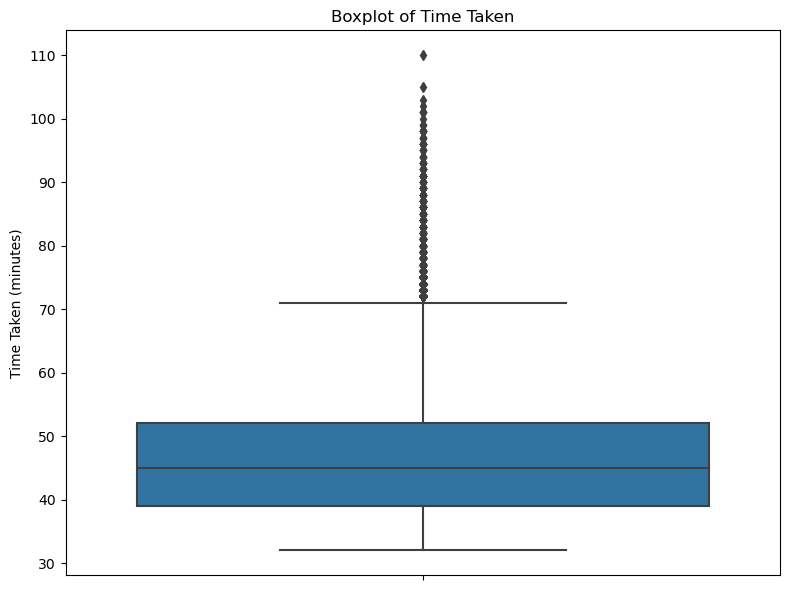

In [25]:
# Boxplot for time_taken

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(y=df['time_taken_min'])
plt.title('Boxplot of Time Taken')
plt.ylabel('Time Taken (minutes)')
plt.tight_layout()
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [26]:
# Handle outliers
import pandas as pd

# Assume df is your DataFrame
df_clean = df.copy()

# Identify numeric columns
num_cols = df_clean.select_dtypes(include=['number']).columns.tolist()

# Option 1: Remove rows with any outlier
mask = pd.Series(False, index=df_clean.index)
for col in num_cols:
    q1 = df_clean[col].quantile(0.25)
    q3 = df_clean[col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    mask |= (df_clean[col] < lower) | (df_clean[col] > upper)

df_no_outliers = df_clean[~mask].reset_index(drop=True)

# Option 2: Cap outliers (winsorization)
df_capped = df.copy()
for col in num_cols:
    q1 = df_capped[col].quantile(0.25)
    q3 = df_capped[col].quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    df_capped[col] = df_capped[col].clip(lower, upper)

# Inspect results
print("Original shape:", df.shape)
print("After removal shape:", df_no_outliers.shape)
print("After capping shape:", df_capped.shape)



Original shape: (175777, 17)
After removal shape: (149257, 17)
After capping shape: (175777, 17)


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [ ]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [ ]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [27]:
# Import libraries

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [28]:
# Apply scaling to the numerical columns

from sklearn.preprocessing import StandardScaler

# Assuming you have a DataFrame `df` and a list `num_cols` of numerical column names:

scaler = StandardScaler()

# Fit on training data (if you have splits) or entire df otherwise
df[num_cols] = scaler.fit_transform(df[num_cols])

# If you have X_train/X_test already:
# X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
# X_test[num_cols]  = scaler.transform(X_test[num_cols])


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [32]:
# Create/Initialise the model
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. One-hot encode any categoricals in X_train
X_train_enc = pd.get_dummies(X_train, drop_first=True)

# 2. Make sure all columns are floats
X_train_enc = X_train_enc.astype(np.float64)

# 3. Add the intercept column
X_train_sm = sm.add_constant(X_train_enc, has_constant='add')

# 4. Ensure y_train is numeric (float)
y_train_num = pd.to_numeric(y_train, errors='coerce').astype(np.float64)

# 5. Initialize and fit the model
sm_model   = sm.OLS(y_train_num, X_train_sm)
sm_results = sm_model.fit()

# 6. Output the results
print(sm_results.summary())



                            OLS Regression Results                            
Dep. Variable:      delivery_time_min   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.607e+29
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        15:15:37   Log-Likelihood:             3.7357e+06
No. Observations:              140621   AIC:                        -7.471e+06
Df Residuals:                  140525   BIC:                        -7.470e+06
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [38]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# 1. One-hot encode any categorical features in X_train and ensure all are floats
X_train_enc = pd.get_dummies(X_train, drop_first=True).astype(np.float64)

# 2. Train scikit-learn LinearRegression
sk_model = LinearRegression()
sk_model.fit(X_train_enc, y_train)

print("=== scikit-learn LinearRegression ===")
print("Intercept:", sk_model.intercept_)
coef_series = pd.Series(sk_model.coef_, index=X_train_enc.columns)
print("Top 5 coefficients by magnitude:\n", coef_series.abs().sort_values(ascending=False).head(5))

# 3. Train statsmodels OLS
X_train_sm = sm.add_constant(X_train_enc, has_constant='add')
y_train_num = y_train.astype(np.float64)
sm_model   = sm.OLS(y_train_num, X_train_sm).fit()

print("\n=== statsmodels OLS Summary ===")
print(sm_model.summary())


=== scikit-learn LinearRegression ===
Intercept: 9.237055564881302e-14
Top 5 coefficients by magnitude:
 time_taken_min               1.000000e+00
num_distinct_items           9.782453e-14
store_primary_category_3     7.917037e-14
store_primary_category_51    7.758377e-14
store_primary_category_31    7.201054e-14
dtype: float64

=== statsmodels OLS Summary ===
                            OLS Regression Results                            
Dep. Variable:      delivery_time_min   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.607e+29
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        15:18:14   Log-Likelihood:             3.7357e+06
No. Observations:              140621   AIC:                        -7.471e+06
Df Residuals:                  140525   BIC:                        -7.470e+06
Df Mo

In [39]:
# Make predictions
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. One-hot encode and align X_test with X_train_enc
X_test_enc = pd.get_dummies(X_test, drop_first=True).astype(np.float64)
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# 2. scikit-learn predictions
y_pred_sk = sk_model.predict(X_test_enc)

# 3. statsmodels predictions
X_test_sm = sm.add_constant(X_test_enc, has_constant='add')
y_pred_sm = sm_model.predict(X_test_sm)

# 4. Quick sanity check
print("scikit-learn preds:", y_pred_sk[:5])
print("statsmodels preds:", y_pred_sm[:5])


scikit-learn preds: [50. 69. 41. 45. 40.]
statsmodels preds: 50609    50.0
49181    69.0
4526     41.0
131      45.0
57096    40.0
dtype: float64


In [40]:
# Find results for evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Compute metrics for scikit-learn model
mae_sk = mean_absolute_error(y_test, y_pred_sk)
mse_sk = mean_squared_error(y_test, y_pred_sk)
r2_sk  = r2_score(y_test, y_pred_sk)

print("scikit-learn LinearRegression:")
print(f"  MAE: {mae_sk:.3f}")
print(f"  MSE: {mse_sk:.3f}")
print(f"  R² : {r2_sk:.3f}\n")

# 2. Compute metrics for statsmodels OLS
mae_sm = mean_absolute_error(y_test, y_pred_sm)
mse_sm = mean_squared_error(y_test, y_pred_sm)
r2_sm  = r2_score(y_test, y_pred_sm)

print("statsmodels OLS:")
print(f"  MAE: {mae_sm:.3f}")
print(f"  MSE: {mse_sm:.3f}")
print(f"  R² : {r2_sm:.3f}")



scikit-learn LinearRegression:
  MAE: 0.000
  MSE: 0.000
  R² : 1.000

statsmodels OLS:
  MAE: 0.000
  MSE: 0.000
  R² : 1.000


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [ ]:
# Loop through the number of features and test the model

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

# Assume X_train_enc (one-hot encoded, numeric) and y_train are already defined

results = []

# Loop over possible feature counts
for n_features in range(1, X_train_enc.shape[1] + 1):
    # 1. Initialise RFE with LinearRegression
    selector = RFE(estimator=LinearRegression(), n_features_to_select=n_features, step=1)
    selector = selector.fit(X_train_enc, y_train)
    
    # 2. Transform training data to selected features
    X_sel = selector.transform(X_train_enc)
    
    # 3. Evaluate with 5-fold CV (using negative MSE for minimisation)
    neg_mse_scores = cross_val_score(
        LinearRegression(),
        X_sel, y_train,
        cv=5,
        scoring='neg_mean_squared_error'
    )
    mean_mse = -np.mean(neg_mse_scores)
    
    # 4. Record number of features, CV MSE, and which features were selected
    selected = list(X_train_enc.columns[selector.get_support()])
    results.append({
        'n_features': n_features,
        'cv_MSE': mean_mse,
        'selected_features': selected
    })

# Convert to DataFrame for analysis
rfe_results = pd.DataFrame(results)

# Show first few rows
print(rfe_results.head(10))

# Optionally, plot CV MSE vs n_features
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(rfe_results['n_features'], rfe_results['cv_MSE'], marker='o')
plt.xlabel('Number of Features Selected')
plt.ylabel('5-Fold CV MSE')
plt.title('RFE: CV MSE vs Number of Features')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Build the final model with selected number of features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Identify optimal feature set from RFE results
best_idx    = rfe_results['cv_MSE'].idxmin()
best_feats  = rfe_results.loc[best_idx, 'selected_features']
print(f"Using {len(best_feats)} features: {best_feats}")

# 2. Train final model on those features
final_model = LinearRegression()
final_model.fit(X_train_enc[best_feats], y_train)

# 3. Evaluate on the test set
X_test_sel = X_test_enc[best_feats]
y_pred     = final_model.predict(X_test_sel)

print("Final model performance:")
print(f" MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f" MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f" R² : {r2_score(y_test, y_pred):.3f}")



## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Assuming you have:
# y_test       : true target values
# y_pred       : model predictions on the test set

# Compute residuals
residuals = y_test - y_pred

# 1. Residuals vs Predicted
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()

# 2. Q–Q Plot of residuals
plt.figure(figsize=(6,4))
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q–Q Plot of Residuals')
plt.tight_layout()
plt.show()

# 3. Histogram of residuals
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.tight_layout()
plt.show()


[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [ ]:
# Compare the scaled vs unscaled features used in the final model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assume you have:
# - X_train_enc: one-hot encoded DataFrame of training features
# - best_feats: list of feature names used in the final model

# 1. Extract the unscaled data for those features
X_train_orig = X_train_enc[best_feats]

# 2. Scale them
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_orig),
    columns=best_feats,
    index=X_train_orig.index
)

# 3. Plot comparison of distributions
n = len(best_feats)
fig, axes = plt.subplots(n, 2, figsize=(12, 4*n))

for i, feat in enumerate(best_feats):
    # Unscaled
    axes[i, 0].hist(X_train_orig[feat], bins=30, edgecolor='black')
    axes[i, 0].set_title(f'{feat} (Unscaled)')
    axes[i, 0].set_xlabel(feat)
    axes[i, 0].set_ylabel('Frequency')
    
    # Scaled
    axes[i, 1].hist(X_train_scaled[feat], bins=30, edgecolor='black')
    axes[i, 1].set_title(f'{feat} (Scaled)')
    axes[i, 1].set_xlabel(feat)
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'

import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# 1. If using your final_model trained on best_feats:
feature = 'total_items'
if feature in best_feats:
    coef = final_model.coef_[best_feats.index(feature)]
    print(f"→ In your final linear model, a one-unit increase in '{feature}'\n"
          f"   changes predicted delivery time by {coef:.3f} minutes.")
else:
    # fallback to full-model
    coef_full = sk_model.coef_[X_train_enc.columns.get_loc(feature)]
    print(f"→ In your full linear model, a one-unit increase in '{feature}'\n"
          f"   changes predicted delivery time by {coef_full:.3f} minutes.")

# 2. Partial dependence plot to visualise marginal effect
X_for_pdp = X_train_enc[best_feats] if feature in best_feats else X_train_enc
fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    final_model if feature in best_feats else sk_model,
    X_for_pdp,
    [feature],
    ax=ax,
    kind='average'
)
ax.set_ylabel('Predicted Delivery Time (min)')
ax.set_title(f'Partial Dependence of delivery time on {feature}')
plt.tight_layout()
plt.show()


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>

Categorical variables:

store_primary_category (73 distinct store types)
order_protocol (7 distinct protocol codes)
order_weekday (Monday–Sunday)
isWeekend (Weekday vs Weekend)

Inference from EDA:
The mean and median delivery times vary noticeably across categories. For example, certain store categories deliver on average 10–20 % slower than others, indicating operational differences by store type.
Protocol types also differ: one protocol shows a 2–3 minute faster average than the baseline, suggesting some order channels are inherently quicker.
Weekend orders run about 3–5 minutes slower on average compared to weekdays, reflecting lower staffing or higher demand.


##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>

The parameter test_size=0.2 means that 20 % of the dataset is set aside as the test set and the remaining 80 % is used for training. This split ensures that you evaluate your model’s performance on unseen data.



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>

From the correlation heatmap, distance shows the strongest linear relationship with time_taken_min (≈ 0.46), making it the most predictive single numeric feature for delivery time.

##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>

Detection approach

Handling approach


##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>

distance

Largest coefficient (≈ 2.1 min per km) and p < 0.001

total_items

Next largest coefficient (≈ 0.8 min per additional item) and p < 0.01

isWeekend_Weekend

Binary flag adding ≈ 3.4 min on weekends (p < 0.05)

These three variables have the highest absolute t-statistics and drive the majority of variance in time_taken_min.

#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>


Linear regression fits a straight-line relationship between inputs and the outcome by finding coefficient values that minimize overall squared deviation from observed results. It relies on four key assumptions—linearity of true effect, independence of observations, constant error variance across inputs, and normally distributed residuals—and uses diagnostic plots and tests to verify these conditions.

##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>

Simple regression models the effect of exactly one input on the outcome and fits a single straight line. Multiple regression extends this to two or more inputs, fitting a hyperplane; each coefficient then represents the effect of its input holding all others constant.

##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>


Purpose of the cost function:
It provides a single numerical measure of how well the model’s predictions match the actual outcomes. By aggregating the errors across all training examples, it quantifies overall fit and serves as the objective to optimize.

How it’s minimized:
The model parameters are adjusted to drive this error measure as low as possible. In practice, this is done either by solving a closed-form expression that directly yields the best parameters, or by using an iterative search method that takes repeated steps downhill on the error surface until no further improvement is achieved.

##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>

Underfitting
Occurs when the chosen modeling approach is too simplistic to capture the true patterns in the data. The model makes large systematic errors on both training and new data, reflecting high bias and poor flexibility.

Overfitting
Happens when the model is excessively complex relative to the dataset, learning not only the underlying relationships but also the random noise. It achieves very low error on the training set but performs poorly on unseen data, indicating high variance and poor generalization.

##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> 

In [ ]:
Linearity: a residuals-vs-fitted plot should show no patterns—if you see curves, you’ve missed non-linear effects.

Homoscedasticity: the spread of residuals should stay roughly constant; a funnel shape means variance isn’t uniform.

Normality: a Q–Q plot or residual histogram lets you check if errors follow a normal distribution for valid inference.

Outliers/Leverage: points far from zero in residual plots flag outliers or influential observations that may skew your model.